In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_10 import *

In [3]:
from fastai.vision.all import URLs,untar_data
path = untar_data(URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

## Mixup 

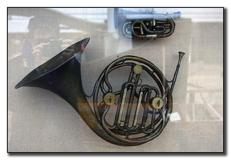

In [4]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

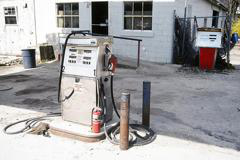

In [5]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

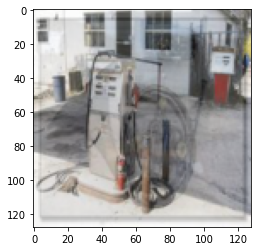

In [6]:
mixed_up = ll.train.x[0] * 0.3 + ll.train.x[4000] * 0.7
plt.imshow(mixed_up.permute(1,2,0));

In [7]:
# PyTorch has a log-gamma but not a gamma, so we'll create one
Γ = lambda x: x.lgamma().exp()

In [8]:
facts = [math.factorial(i) for i in range(7)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  


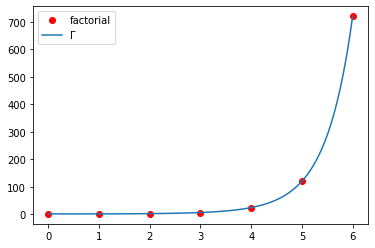

In [9]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), Γ(torch.linspace(0,6)+1))
plt.legend(['factorial','Γ']);

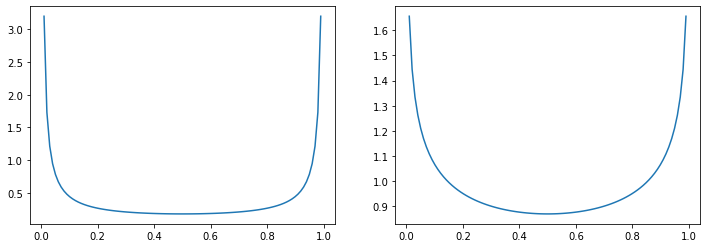

In [10]:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor([α])
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
#     ax.set_title(f"α={α:.1}")

In [11]:
#export
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)    

In [12]:
#export
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

In [13]:
#export
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [14]:
nfs = [32,64,128,256,512]

In [15]:
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [16]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

In [17]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [19]:
learn.fit(10)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.268116,0.304573,1.951185,0.345732,00:06
1,2.108452,0.335410,1.783759,0.388790,00:06
2,1.979727,0.368677,1.752425,0.429809,00:06
3,1.861013,0.424649,1.813293,0.400510,00:06
4,1.802359,0.459077,4.322412,0.404586,00:06
5,1.702067,0.506389,1.432605,0.533248,00:06
6,1.630167,0.545359,1.361167,0.555924,00:06
7,1.559888,0.583166,1.323652,0.593121,00:06
8,1.494339,0.609779,1.334826,0.590573,00:06
9,1.461642,0.635125,1.312833,0.593376,00:06
